In [172]:
import json
import os
import math
from collections import defaultdict
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import numpy as np
from pathlib import Path

In [173]:
# Input: path to json file containing nccut inline chain objects
# Task: Loads json file structure as python dict
# Output: All inline chain dicts containing latitude and longitude points
def unpack_jsons(processed_path):
    
    with open(processed_path) as fin:
        chains = json.load(fin)

    filename = os.path.basename(processed_path)
    date_str = filename.replace(".json", "")
    return chains, date_str

# Input: endpoints of the segment in (lat, lon)
# Task: Computes great-circle bearing of chain relative to true north
# Output: Bearing in degrees
def compute_segment_bearing(lat1, lon1, lat2, lon2):
    φ1, φ2 = math.radians(lat1), math.radians(lat2)
    Δλ = math.radians(lon2 - lon1)
    x = math.sin(Δλ) * math.cos(φ2)
    y = math.cos(φ1) * math.sin(φ2) - math.sin(φ1) * math.cos(φ2) * math.cos(Δλ)
    θ = math.degrees(math.atan2(x, y))
    bearing = (θ + 360.0) % 360.0 # put in (0,360)
    bearing % 90.0 # mod to (0,90)
    return bearing

def circular_mean_deg(angles):
    angles = np.deg2rad(angles)
    return (np.degrees(np.arctan2(
        np.mean(np.sin(angles)),
        np.mean(np.cos(angles))
    )) + 360) % 90



In [174]:
input_dir = Path("Sentinel2_cracks_processed")
rows = []

# Unpack jsons, collect coordinates, store as a row in a pd dataframe
for json_path in sorted(input_dir.glob("*.json*")):
    chains, date = unpack_jsons(json_path)
    for name, chain in chains.items():
        coords = list(zip(chain["lat"], chain["lon"]))
        rows.append([date, name, coords])

all_cracks_df = pd.DataFrame(rows, columns=["date", "crack", "coords"])

In [175]:
from geopy import distance
lengths = []
all_bearings = []

for _, row in all_cracks_df.iterrows():

    coords = row["coords"] 
    length = 0.0
    segment_bearings = []
    
    if coords is not None and len(coords) > 1:

        for p1, p2 in zip(coords[:-1], coords[1:]):
            seg_len = abs(distance.distance(p1, p2).km)
            length += seg_len

            segment_bearings.append(
                compute_segment_bearing(p1[0], p1[1], p2[0], p2[1])
            )
    lengths.append(length)
    all_bearings.append(segment_bearings)
all_cracks_df["length"] = lengths
all_cracks_df["bearings"] = all_bearings


## Unpack ERA5 Winds
- Open datasets with xarray 
- Convert to meteorological wind direction: (0, 360) degress

In [176]:
import xarray as xr
import numpy as np

# Open three datasets
ds1 = xr.open_dataset("era5_2023_2025_06.grib", engine="cfgrib")
ds2 = xr.open_dataset("era5_2014_2023_05.grib", engine="cfgrib")
ds3 = xr.open_dataset("era5_2014_05.grib", engine="cfgrib")

# Concatenate along time dimension
ds = xr.concat([ds1, ds2, ds3], dim="time")

# Make sure time is sorted incase ranges overlap
ds = ds.sortby("time")

# Extract components
u = ds["u10"]
v = ds["v10"]

# Latitude weights
weights = np.cos(np.radians(ds["latitude"]))
weights.name = "weights"

# Weighted spatial mean, then resample to daily mean
u_daily = u.weighted(weights).mean(dim=("latitude", "longitude")).resample(time="1D").mean()
v_daily = v.weighted(weights).mean(dim=("latitude", "longitude")).resample(time="1D").mean()

# Convert to primary wind direction (degrees, meteorological convention)
primary_dir = (180 + np.degrees(np.arctan2(u_daily, v_daily))) % 360

# Put in dataframe
primary_dir = primary_dir.to_dataframe(name="primary_wind_dir_deg")

# Wind speed preparation
weights = np.cos(np.radians(ds["latitude"]))
weights.name = "weights"

u_daily = (
    u.weighted(weights)
     .mean(dim=("latitude", "longitude"))
     .resample(time="1D")
     .mean()
)

v_daily = (
    v.weighted(weights)
     .mean(dim=("latitude", "longitude"))
     .resample(time="1D")
     .mean()
)

# Wind speed magnitude
speed_daily = np.sqrt(u_daily**2 + v_daily**2)

speed_df = speed_daily.to_dataframe(name="wind_speed")

/Users/makov/miniconda3/envs/subzero/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode the variable 'step' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it will rely on the presence of a timedelta64 'dtype' attribute, which is now xarray's default way of encoding timedelta64 values.
To continue decoding into a timedelta64 dtype, either set `decode_timedelta=True` when opening this dataset, or add the attribute `dtype='timedelta64[ns]'` to this variable on disk.
To opt-in to future behavior, set `decode_timedelta=False`.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/Users/makov/miniconda3/envs/subzero/lib/python3.13/site-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version, xarray will not decode the variable 'step' into a timedelta64 dtype based on the presence of a timedelta-like 'units' attribute by default. Instead it w

# Plot Raw Wind Direction Rose

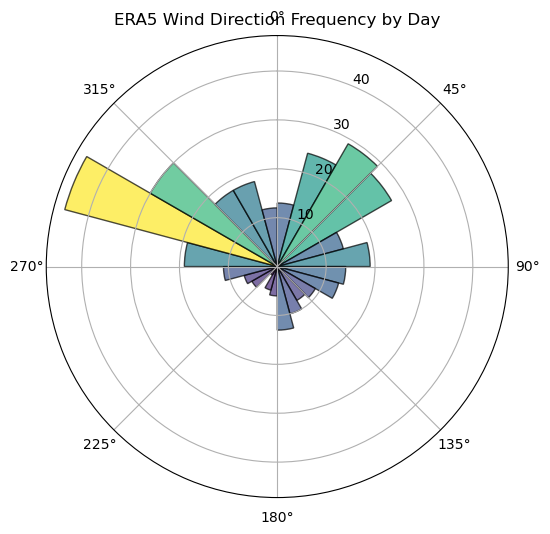

In [177]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 6))
colors = plt.cm.tab10.colors

primary_dir.index = pd.to_datetime(primary_dir.index)
all_angles = []

for date in primary_dir.index:
    wind_angle_deg = primary_dir.loc[date, "primary_wind_dir_deg"]
    if pd.isna(wind_angle_deg):
        continue

    wind_angle = np.radians(wind_angle_deg)

    # ensure numeric
    if np.isfinite(wind_angle):
        all_angles.append(wind_angle)

# Define histogram parameters
n_bins = 24  # 15 degrees per bin
bins = np.linspace(0, 2*np.pi, n_bins + 1)

counts, _ = np.histogram(all_angles, bins=bins)
width = 2 * np.pi / n_bins

bars = ax.bar(
    bins[:-1], counts,
    width=width,
    align='edge',
    color=colors[0],
    edgecolor='k',
    alpha=0.7
)

# Optional: color scale by frequency
for bar, count in zip(bars, counts):
    bar.set_facecolor(plt.cm.viridis(count / counts.max() if counts.max() > 0 else 0))

# formatting
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_title("ERA5 Wind Direction Frequency by Day", va='bottom')

plt.show()

## Compute Von Mises Concentration Factor, view scatterplot

(Bearing) Resultant length R: 0.8815536717358019
(Bearing) Von Mises kappa: 4.520767513230708
(Diff) Resultant length R: 0.5022667332851789
(Diff) Von Mises kappa: 1.157878573578954


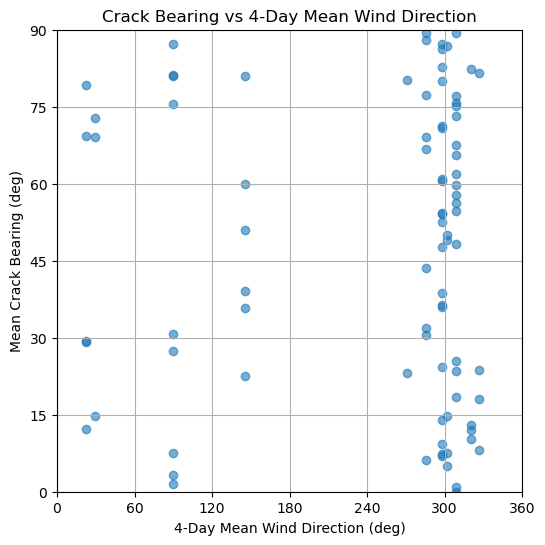

In [178]:
import statsmodels.api as sm

# ensure date alignment
all_cracks_df["date"] = pd.to_datetime(all_cracks_df["date"])

# get crack level bearing
all_cracks_df["crack_bearings"] = (
    all_cracks_df["bearings"].apply(circular_mean_deg)
)
# take 4-day mean
theta = np.deg2rad(primary_dir["primary_wind_dir_deg"])

sin_mean = np.sin(theta).rolling(4, min_periods=4).mean()
cos_mean = np.cos(theta).rolling(4, min_periods=4).mean()

rolling_circ_mean = (np.degrees(np.arctan2(sin_mean, cos_mean)) + 360) % 360

rolling_df = rolling_circ_mean.to_frame(name="wind_dir_4day_mean")

all_cracks_df = all_cracks_df.merge(
    rolling_df,
    left_on="date",
    right_index=True,
    how="left"
)

cols = ["wind_dir_4day_mean", "crack_bearings"]
df_reg = all_cracks_df[cols].dropna()


theta = np.deg2rad(df_reg["wind_dir_4day_mean"])
phi   = np.deg2rad(df_reg["crack_bearings"])

C = np.mean(np.cos(phi))
S = np.mean(np.sin(phi))

R = np.sqrt(C**2 + S**2)
# Best & Fisher 1981
if R < 0.53:
    kappa = 2*R + R**3 + 5*R**5/6
elif R < 0.85:
    kappa = -0.4 + 1.39*R + 0.43/(1-R)
else:
    kappa = 1/(R**3 - 4*R**2 + 3*R)

print("(Bearing) Resultant length R:", R)
print("(Bearing) Von Mises kappa:", kappa)

diff = theta - phi

C = np.mean(np.cos(diff))
S = np.mean(np.sin(diff))

R = np.sqrt(C**2 + S**2)
# Best & Fisher 1981
if R < 0.53:
    kappa = 2*R + R**3 + 5*R**5/6
elif R < 0.85:
    kappa = -0.4 + 1.39*R + 0.43/(1-R)
else:
    kappa = 1/(R**3 - 4*R**2 + 3*R)

print("(Diff) Resultant length R:", R)
print("(Diff) Von Mises kappa:", kappa)

plt.figure(figsize=(6,6))
plt.scatter(
    df_reg["wind_dir_4day_mean"],
    df_reg["crack_bearings"],
    alpha=0.6
) 

plt.xlabel("4-Day Mean Wind Direction (deg)")
plt.ylabel("Mean Crack Bearing (deg)")
plt.xlim(0, 360)
plt.ylim(0, 90)
plt.xticks(np.arange(0, 361, 60))
plt.yticks(np.arange(0, 91, 15))
plt.grid(True)

plt.title("Crack Bearing vs 4-Day Mean Wind Direction")
plt.show()

                            OLS Regression Results                            
Dep. Variable:                 length   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                   0.04139
Date:                Fri, 13 Feb 2026   Prob (F-statistic):              0.839
Time:                        13:42:10   Log-Likelihood:                -280.75
No. Observations:                  86   AIC:                             565.5
Df Residuals:                      84   BIC:                             570.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               5.3565      3.031     

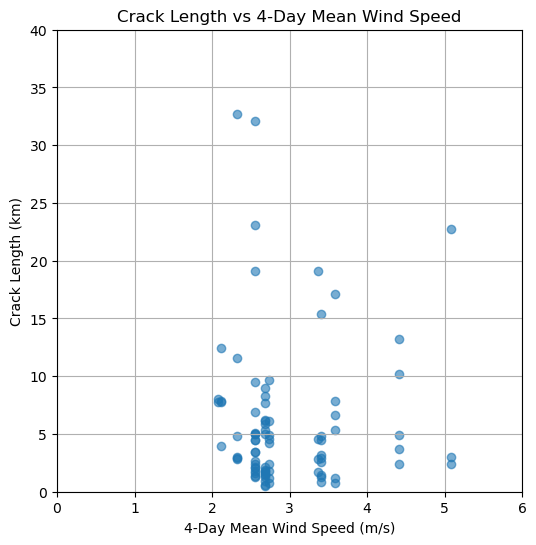

In [179]:
# Compute 4-day rolling mean wind speed
speed_4day = speed_df["wind_speed"].rolling(4, min_periods=4).mean()
speed_4day_df = speed_4day.to_frame(name="wind_speed_4day")

all_cracks_df["wind_speed_4day"] = (
    all_cracks_df["date"].map(speed_4day_df["wind_speed_4day"])
)

# Run linear regression
cols = ["wind_speed_4day", "length"]
df_reg = all_cracks_df[cols].dropna()

X = sm.add_constant(df_reg["wind_speed_4day"])
y = df_reg["length"]

model = sm.OLS(y, X).fit()
print(model.summary())

plt.figure(figsize=(6,6))
plt.scatter(
    df_reg["wind_speed_4day"],
    df_reg["length"],
    alpha=0.6
) 

plt.xlabel("4-Day Mean Wind Speed (m/s)")
plt.ylabel("Crack Length (km)")
plt.xlim(0, 6)
plt.ylim(0, 40)
plt.grid(True)

plt.title("Crack Length vs 4-Day Mean Wind Speed")
plt.show()
